In [1]:
from evaluation import build_eval_env

env = build_eval_env(0.01, 42)

In [2]:
#cvel -> COM based spatial velocities, qvel -> 3D angular velocities
#cvel[omegx, omegy, omegz, vx, vy, vz]
env.unwrapped.data.cvel[env.unwrapped.model.body("trunk").id][3]

np.float64(0.0)

In [5]:
#torque constants
kp = env.unwrapped.model.actuator_gainprm[:, 0]
kd = env.unwrapped.model.dof_damping[6:]
kp, kd

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100.]),
 array([1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2.]))

In [6]:
kd.shape, kp.shape

((12,), (12,))

0.9540632933157362


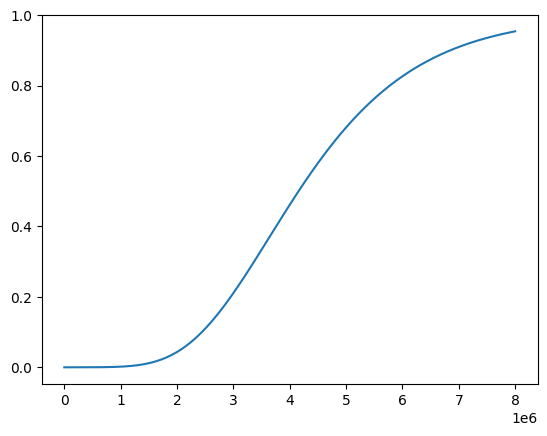

In [2]:
import matplotlib.pyplot as plt
import numpy as np

li = [0.000003]
for _ in range(8_000_000):
    li.append(li[-1]**0.9999993)
print(li[-1])
plt.plot(li)

In [13]:
env.action_space.shape

(12,)

In [14]:
env.action_space

Box([-0.863 -0.686 -2.818 -0.863 -0.686 -2.818 -0.863 -0.686 -2.818 -0.863
 -0.686 -2.818], [ 0.863  4.501 -0.888  0.863  4.501 -0.888  0.863  4.501 -0.888  0.863
  4.501 -0.888], (12,), float32)

In [ ]:
env.unwrapped.data.cfrc_ext.shape

(14, 6)

In [70]:
#ground impact forces
foot_names = [
    "FR_calf", 
    "FL_calf", 
    "RR_calf", 
    "RL_calf"
] 
foot_ids = [env.unwrapped.model.body(name).id for name in foot_names]
env.unwrapped.data.cfrc_ext[foot_ids, -1]

array([  94.75637041, -192.44179801,  414.83572669, -189.35811317])

In [71]:
foot_ids

[4, 7, 10, 13]

In [25]:
obs, info = env.reset()
obs.shape

(115,)

In [28]:
info

{'x_position': np.float64(0.03692232048938665),
 'y_position': np.float64(-0.08771567938555705),
 'distance_from_origin': np.float64(0.09516983850144341)}

In [29]:
obs[42::6].shape

(13,)

In [ ]:
def H(quat1, quat2):
            # ref: https://en.wikipedia.org/wiki/Quaternion#Hamilton_product
            a1, b1, c1, d1 = quat1
            a2, b2, c2, d2 = quat2

            e1 = a1*a2 - b1*b2 - c1*c2 - d1*d2
            e2 = a1*b2 + b1*a2 + c1*d2 - d1*c2
            e3 = a1*c2 - b1*d2 + c1*a2 + d1*b2
            e4 = a1*d2 + b1*c2 - c1*b2 + d1*a2

            return np.array([e1, e2, e3, e4])

P = [0, 1, 0, 0]
R = [0.7071068, 0.0, 0.7071068, 0.0]
Rinv = [0.7071068, -0.0, -0.7071068, -0.0]

print(H(H(R, P), Rinv))

w, x, y, z = R


array([ 0.        ,  0.        ,  0.        , -1.00000005])

In [41]:
from copy import deepcopy
last_joint_ang = deepcopy(env.unwrapped.data.qpos[7:])
last_joint_ang.shape

(12,)

In [45]:
buh = env.unwrapped.data.qpos
buh

array([ 0.03692232, -0.08771568,  0.68078877,  1.06121325, -0.03094064,
        0.09916027, -0.00452429,  0.05646396,  0.03926197,  0.0333643 ,
       -0.06254452, -0.05531401,  0.05666127, -0.08591145,  0.07192071,
        0.03614761,  0.04292418,  0.08321117, -0.08858068])

In [62]:
env.step(np.ones_like(buh[7:]))
buh

array([ 0.08316863, -0.07679102,  0.35360831,  0.93691282, -0.34916656,
        0.01227961,  0.01123854,  0.86281041,  0.99411239, -0.89305483,
        0.86504493,  1.14226389, -0.87528761,  0.86280365,  1.04737948,
       -0.94871629,  0.84510015,  0.98248453, -0.88909988])

In [63]:
ground_contact_forces = obs[37:].reshape(13,6)[foot_ids]
ground_contact_forces

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [66]:
from gymnasium.wrappers import RecordVideo

env = RecordVideo(env, "./evals/test")
obs, _ = env.reset()
done = False
total_reward = 0
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    ground_contact_forces = obs[37:].reshape(13,6)[foot_ids]
    print(f"\r{ground_contact_forces}")


[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [-1.         -1.          0.69360428  1.         -1.          0.81483251]
 [ 1.          1.         -0.69360428 -1.          1.         -0.81483251]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [-1.  1.  1.  1. -1.  1.]
 [ 1. -1. -1. -1.  1. -1.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [-1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1.]]
[[ 1. -1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1. -1.]]
[[-1. -1. -1.  1.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1.  1. -1.]]
[[-1. -1

In [ ]:
from copy import copy
gce = copy(env.unwrapped.data.cfrc_ext[foot_ids])
g : np.ndarray = (np.sum(gce, axis=-1) > 0).astype(float)
g

array([1., 0., 1., 0.])

In [82]:
np.diag(g)

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [ ]:
site_ids = [env.unwrapped.data.site(name).id for name in ['FR', 'FL', 'RR', 'RL']]
env.unwrapped.data.cvel[foot_ids][:, 3:]

array([[-8.83868095e-04,  1.36914437e-04, -4.72324317e-04],
       [ 2.52073003e-04,  4.28694840e-05,  1.15451592e-04],
       [ 9.74099144e-05, -3.21594522e-04,  5.20013567e-05],
       [ 2.87838701e-04,  3.90600393e-05,  1.76898012e-04]])